# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **Hardefa Rogonondo** | hardefarogonondo@gmail.com | **Food.com Recipe Recommendation Engine** |

# II. Notebook Target Definition

This notebook focuses on the model training and evaluation stages of the Food.com Recipe Recommendation Engine Project. Utilizing the user-item matrix established in the earlier phase, we employ two recommendation algorithms: Singular Value Decomposition (SVD) and K-Nearest Neighbors (KNN). The effectiveness of these models is gauged using Root Mean Square Error (RMSE) and Mean Absolute Error (MAE) for both algorithms, with an additional Cosine Similarity metric for KNN. These metrics offer a streamlined yet comprehensive perspective on each model's performance. Our aim is to build a recommendation engine that excels in suggesting highly relevant recipes, thus elevating users' culinary experiences.

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## III.B. Import Data

In [2]:
train_sparse_matrix = pd.read_pickle(
    '../../../data/processed/train_sparse_matrix.pkl')
test_sparse_matrix = pd.read_pickle(
    '../../../data/processed/test_sparse_matrix.pkl')

# IV. Models Training and Evaluation

## IV.A. Data Shape Inspection

In [3]:
train_sparse_matrix.shape, test_sparse_matrix.shape

((4447, 12395), (4447, 12395))

## IV.B. Model Training

In [4]:
def train_svd_model(train_matrix, test_matrix, k=20):
    train_matrix = train_matrix.astype(np.float32)
    test_matrix = test_matrix.astype(np.float32)
    u, s, vt = svds(train_matrix, k=k)
    s_matrix = np.diag(s)
    svd_model = {"u": u, "s": s_matrix, "vt": vt}
    reconstructed_matrix = np.dot(np.dot(u, s_matrix), vt)
    y_true = np.squeeze(test_matrix[test_matrix.nonzero()].A)
    y_pred = np.squeeze(reconstructed_matrix[test_matrix.nonzero()])
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    return svd_model, {"RMSE": rmse, "MAE": mae}


def train_knn_model(train_matrix, test_matrix, n_neighbors=5):
    model_knn = NearestNeighbors(
        metric='cosine', algorithm='brute', n_neighbors=n_neighbors)
    model_knn.fit(train_matrix)
    y_pred = np.zeros(test_matrix.shape)
    for i in range(test_matrix.shape[0]):
        distances, indices = model_knn.kneighbors(test_matrix.getrow(
            i).toarray().reshape(1, -1), return_distance=True)
        distances = distances.flatten()
        indices = indices.flatten()
        weights = 1 / (1 + distances)
        neighbors_data = train_matrix[indices].toarray()
        y_pred[i] = np.dot(weights, neighbors_data) / np.sum(weights)
    test_nz_row, test_nz_col = test_matrix.nonzero()
    y_true = np.array(test_matrix[test_nz_row, test_nz_col]).flatten()
    non_zero_pred = np.array(y_pred[test_nz_row, test_nz_col]).flatten()
    rmse = mean_squared_error(y_true, non_zero_pred, squared=False)
    mae = mean_absolute_error(y_true, non_zero_pred)
    cosine_similarity = np.mean(1 / (1 + np.array(distances)))
    return model_knn, {"RMSE": rmse, "MAE": mae, "CosineSimilarity": cosine_similarity}

### IV.B.1. Singular Value Decomposition Model

In [5]:
svd_model, svd_metrics = train_svd_model(
    train_sparse_matrix, test_sparse_matrix, k=20)

### IV.B.2. K-Nearest Neighbors Model

In [6]:
knn_model, knn_metrics = train_knn_model(
    train_sparse_matrix, test_sparse_matrix, n_neighbors=5)

## IV.C. Models Selection

### IV.C.1. Models Performance Review

In [7]:
models_metrics = pd.DataFrame([svd_metrics, knn_metrics], index=["SVD", "KNN"])
models_metrics

,RMSE,MAE,CosineSimilarity
SVD,4.686328,4.613395,NaN
KNN,4.069910,3.752335,0.5


### IV.C.2. Models Performance Visualization

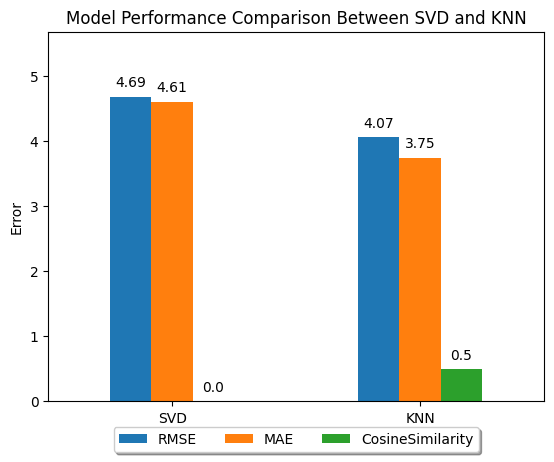

In [8]:
ax = models_metrics.plot(kind='bar')
plt.title("Model Performance Comparison Between SVD and KNN")
plt.ylabel("Error")
plt.xticks(rotation=0)
ylim_max = models_metrics.max().max() + 1
plt.ylim(0, ylim_max)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.legend(loc='upper center', bbox_to_anchor=(
    0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.show()

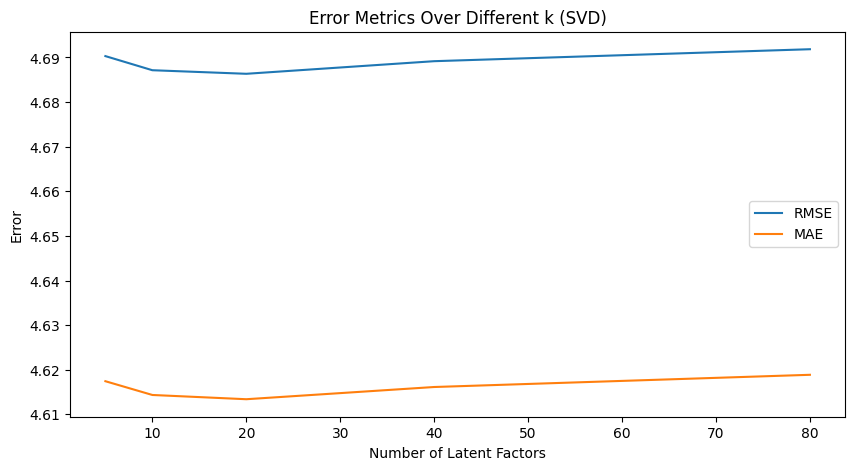

In [9]:
ks = [5, 10, 20, 40, 80]
svd_rmse = []
svd_mae = []
for k in ks:
    _, metrics = train_svd_model(train_sparse_matrix, test_sparse_matrix, k=k)
    svd_rmse.append(metrics["RMSE"])
    svd_mae.append(metrics["MAE"])
plt.figure(figsize=(10, 5))
plt.plot(ks, svd_rmse, label="RMSE")
plt.plot(ks, svd_mae, label="MAE")
plt.title("Error Metrics Over Different k (SVD)")
plt.xlabel("Number of Latent Factors")
plt.ylabel("Error")
plt.legend()
plt.show()

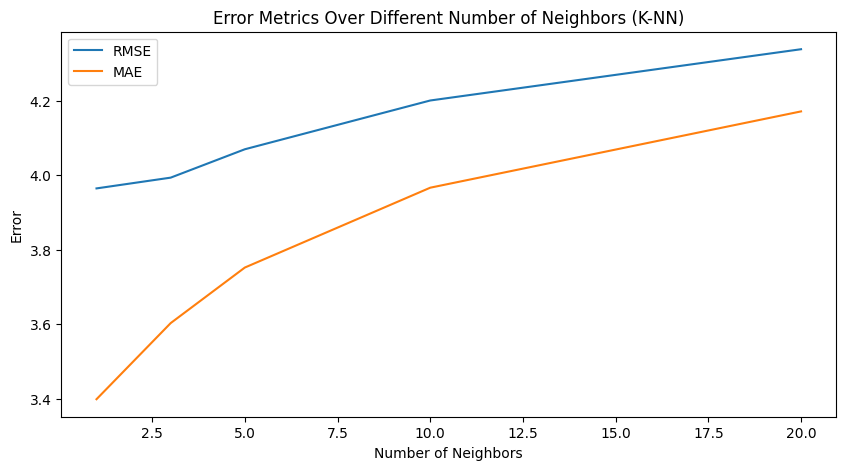

In [10]:
n_neighbors_values = [1, 3, 5, 10, 20]
knn_rmse = []
knn_mae = []
for n in n_neighbors_values:
    _, metrics = train_knn_model(
        train_sparse_matrix, test_sparse_matrix, n_neighbors=n)
    knn_rmse.append(metrics["RMSE"])
    knn_mae.append(metrics["MAE"])
plt.figure(figsize=(10, 5))
plt.plot(n_neighbors_values, knn_rmse, label="RMSE")
plt.plot(n_neighbors_values, knn_mae, label="MAE")
plt.title("Error Metrics Over Different Number of Neighbors (K-NN)")
plt.xlabel("Number of Neighbors")
plt.ylabel("Error")
plt.legend()
plt.show()

### IV.C.3. Export Best Model

In [11]:
with open('../../../models/best_model.pkl', 'wb') as file:
   pickle.dump(knn_model, file)